In [84]:
import pyhf
import pyhf.contrib.utils
import numpy as np
from pathlib import Path
import json

# for plotting / tutorial purposes
import matplotlib.pyplot as plt
from scipy.stats import norm

# for interactivity
from ipywidgets import interact, fixed
import ipywidgets as widgets

# HistFactory

`pyhf` stands for **py**thon-based **H**ist**F**actory.

It's a tool for statistical analysis of data in High Energy Physics.

In this chapter, we will cover
* What HistFactory is in general
* What pyhf is specifically (and what it is not)

## Statistical Analysis

We divide analyses into the type of fit being performed:
* unbinned analysis (based on individual observed events)
* binned analyses (based on aggregation of events)

<center>
    <img alt="WHgamgam unbinned distribution" src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/PAPERS/SUSY-2018-23/fig_04d.png" width=300 style="display: inline" />
    <img alt="SUSY MBJ binned distribution" src="https://atlas.web.cern.ch/Atlas/GROUPS/PHYSICS/CONFNOTES/ATLAS-CONF-2018-041/fig_08a.png" width=400 style="display: inline" />
</center>

Like HistFactory, `pyhf` does not work with unbinned analyses. These will not be covered in the tutorial.

### Why Binned?

Most likely, one performs a binned analysis if no functional form of the p.d.f. is known. Instead, you make approximations (re: educated guesses) as to this functional form through histograms.

What is a histogram? Fundamentally, a histogram is a tool to bookkeep arrays of numbers:
* binning
* counts
* uncertainties

Beyond that, it contains helpful ingredients to make them more user-friendly for common operations (addition, division, etc...).

## What are the ingredients?

Once you have a model, you can perform inference such as
* exclusion fit (upper limits)
* discovery fit (lower limits)
* measurement (two-sided intervals)
* parameter scans
* impact plots
* pull plots
* ...

<img src="https://raw.githubusercontent.com/scikit-hep/pyhf/main/docs/_static/img/README_1bin_example.png" alt="common operation - parameter scan" width=400 />

Let's make up some samples and histograms to go along with it to understand what's going on. Suppose we have an analysis with expected event rate $\lambda$ and measurements $n$. For this simple case, the overall probability of the full experiment is the **joint probability** of each bin:

$$
p(n|\lambda) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b)
$$

A Poisson model is used as we are performing a counting experiment (counting the number of random events with an expected rate) in each bin of the observable.

In [2]:
bins = [1, 2, 3]
observed = [3, 4, 4]
expected_yields = [3.7, 3.2, 2.5]

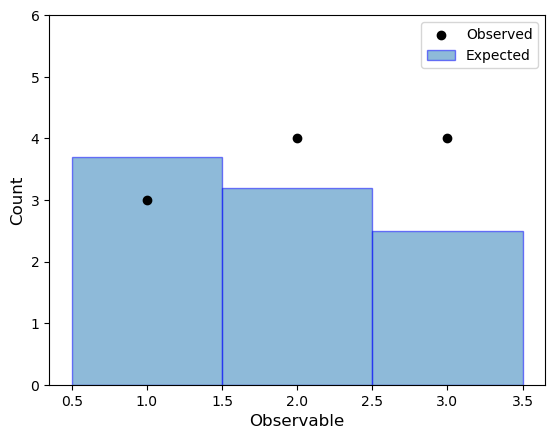

In [3]:
fig, ax = plt.subplots()
ax.bar(bins, expected_yields, 1.0, label=r"Expected", edgecolor="blue", alpha=0.5)
ax.scatter(bins, [3, 4, 4], color="black", label="Observed")
ax.set_ylim(0, 6)
ax.legend()
ax.set_xlabel("Observable", fontsize=12)
ax.set_ylabel("Count", fontsize=12);

However, we don't always often have just a single expected (simulation) sample, and $\lambda$ is often the sum of multiple sample yields

$$
\lambda = \sum_{\mathrm{sample}\ s} \lambda_s
$$

A typical case might be multiple (sub)dominant backgrounds or having a model where the observed events are described by a signal + background p.d.f. The model is then

$$
p(n|\lambda) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b) \qquad \lambda_b = \sum_{\mathrm{sample}\ s} \lambda_{bs}
$$

In [4]:
bins = [1, 2, 3]
observed = [3, 4, 4]
background = [3.0, 1.5, 1.0]
signal = [0.7, 1.7, 1.5]

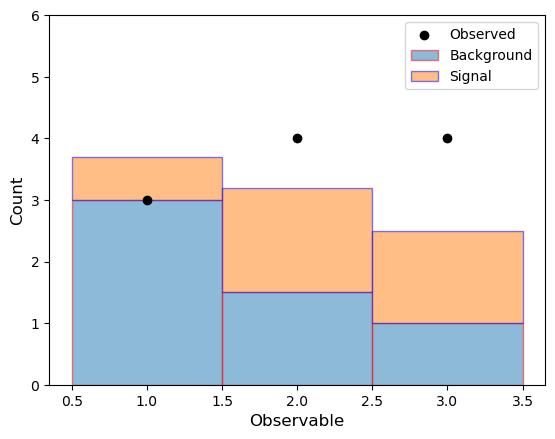

In [5]:
fig, ax = plt.subplots()
ax.bar(bins, background, 1.0, label=r"Background", edgecolor="red", alpha=0.5)
ax.bar(
    bins, signal, 1.0, label=r"Signal", edgecolor="blue", bottom=background, alpha=0.5
)
ax.scatter(bins, [3, 4, 4], color="black", label="Observed")
ax.set_ylim(0, 6)
ax.legend()
ax.set_xlabel("Observable", fontsize=12)
ax.set_ylabel("Count", fontsize=12);

Already, you can see the p.d.f. for this simple case starts expanding to be a little bit more generic, and a little bit more flexible. Now we want to incorporate when the expected yields for signal and backgrounds depend on some **parameters**, perhaps how we applied calibrations to some objects, or how we configured our Monte-Carlo generators, etc.

Suppose we wanted a a normalization factor $\mu_s$ scaling up (or down!) the sample. For example, if we want to parametrize the signal strength (without changing background). So $\lambda$ becomes a function of $\theta = \{\mu\}$ (a set of the parameters that determine the expected event rate), then our p.d.f. expands to be

$$
p(n|\lambda(\mu)) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b(\theta)) \qquad \lambda_b(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{bs}(\theta)
$$

where $\mu_{\mathrm{background}} = 1$

In [6]:
@widgets.interact(mu=(0, 5, 0.1))
def draw_plot(mu=1):
    bins = [1, 2, 3]
    observed = [3, 4, 4]
    background = [3.0, 1.5, 1.0]
    signal = [i * mu for i in [0.7, 1.7, 1.5]]

    print(f"signal: {signal}")
    print(f"background: {background}")
    print(f"observed: {observed}\n")

    fig, ax = plt.subplots()
    ax.bar(bins, background, 1.0, label=r"Background", edgecolor="red", alpha=0.5)
    ax.bar(
        bins,
        signal,
        1.0,
        label=r"Signal",
        edgecolor="blue",
        bottom=background,
        alpha=0.5,
    )
    ax.scatter(bins, [3, 4, 4], color="black", label="Observed")
    ax.set_ylim(0, 6)
    ax.legend()
    ax.set_xlabel("Observable", fontsize=12)
    ax.set_ylabel("Count", fontsize=12);

interactive(children=(FloatSlider(value=1.0, description='mu', max=5.0), Output()), _dom_classes=('widget-inte…

One final thing to finish our build up of a simplified HistFactory model is the concept of **auxiliary measurements**. Perhaps the background sample rate is modified by some normalization parameter, and we've made measurements of this parameter in a separate analysis (e.g. studies of the Jet Energy Scale). These prior experimental studies give a constraint that the parameter lies within a certain range.

For some parameters in a statistical model we don't have prior experimental evidence for their values and must infer its values is the given analysis. These are **unconstrained** parameters ($\eta$) and enter into the main model as parameters of the event rate $\lambda(\theta)$

$$
p(n | \lambda(\theta)).
$$

For many model parameters, their values in the model are constrained by a _constraint term function_, included in the model along with the the main model p.d.f, which describes **auxiliary measurements/data** ($a$) about the model parameter. These are **constrained** parameters ($\chi$) and enter into the model both in the constraint terms and as parameters of the event rate $\lambda(\theta)$

$$
p_\chi(a | \chi)
$$

where $\theta = \{\eta, \chi\}$. This constraining function model is chosen by the physics it represents, but in HistFactory most constraint terms are modeled as a Normal (Gaussian) or Poisson.

With the constraint terms the model expands to be

$$
p(n,a|\lambda(\theta)) = \prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_b | \lambda_b(\theta)) \prod_{\mathrm{constraint}\ \chi} p_\chi(a_\chi | \chi) \qquad \lambda_b(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{bs}(\theta)
$$

where the expected event rate $\lambda_b(\theta)$ is modified from its nominal value by a **chosen interpolation function** that smoothly interpolates between the up- and down-variations $(\pm1 \sigma)$ of the constraint term to provide an event rate modifier for any value of $\chi$.

For this simple example, let's consider a constraint term of a Normal distribution centered at $\mu=0$ ("auxiliary measurement" $a=0$) with $\sigma=1$ for constraining the normalization on the background where an up-variation ($\mu_b = +1$) scales by 1.3, and a down-variation ($\mu_b = -1$) scales by 0.8.

In [7]:
def normal_constraint(mu_b=0.0):
    # auxiliary measurement of 0
    # though note that for Normal observation and mean are symmetric under exchange
    return norm.pdf(0.0, loc=mu_b, scale=1.0)


# selected interpolation function
def interpolate(down, nom, up, alpha):
    if alpha >= 0:
        return (up - nom) * alpha + 1
    else:
        return 1 - (down - nom) * alpha


@widgets.interact(mu=(0, 5, 0.1), mu_b=(-1, 1, 0.1))
def draw_plot(mu=1, mu_b=0):
    bins = [1, 2, 3]
    observed = [3, 4, 4]
    background = [i * interpolate(0.8, 1.0, 1.3, mu_b) for i in [3.0, 1.5, 1.0]]
    signal = [i * mu for i in [0.7, 1.7, 1.5]]

    print(f"signal: {signal}")
    print(f"background: {background}")
    print(f"observed: {observed}")
    print(f"likelihood scaled by: {normal_constraint(mu_b)/normal_constraint(0.0)}\n")

    fig, ax = plt.subplots()
    ax.bar(bins, background, 1.0, label=r"Background", edgecolor="red", alpha=0.5)
    ax.bar(
        bins,
        signal,
        1.0,
        label=r"Signal",
        edgecolor="blue",
        bottom=background,
        alpha=0.5,
    )
    ax.scatter(bins, [3, 4, 4], color="black", label="Observed")
    ax.set_ylim(0, 6)
    ax.legend()
    ax.set_xlabel("Observable", fontsize=12)
    ax.set_ylabel("Count", fontsize=12);

interactive(children=(FloatSlider(value=1.0, description='mu', max=5.0), FloatSlider(value=0.0, description='m…

However, notice that all along, we've been only discussing a single "channel" with 3 bins. The statistical analysis being studied might involve **multiple channels** corresponding to different analysis signal regions and control regions. Therefore, we compute the likelihood as

$$
p_\text{main} = p_\text{channel1} * p_\text{channel2} * p_\text{channel3} \cdots
$$

We then expand out the likelihood definition further across channels

$$
p(n,a|\theta) = \underbrace{\prod_{\mathrm{channel}\ c}\prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_{cb} | \lambda_{cb}(\theta))}_{\text{main}}\, \underbrace{\prod_{\mathrm{constraint}\ \chi} p_\chi(a_\chi | \chi)}_{\text{auxiliary}} \qquad \lambda_{cb}(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{cbs}(\theta)
$$

There are now two pieces of the model:
* the main model, which consists of
  * several channels (regions, histograms, etc), where
  * each channel is a set of Poissons measuring the bin count for an expected value, where
  * the expected value is the sum of various samples, where
  * each samples expected value can be a function of parameters (or modifiers)
* the constraint model, which consists of
  * constraint terms on model parameters, where
  * each constraint term describes auxiliary measurements
  
It should be clear by now that this is quite a lot of pieces to keep track of. This is where HistFactory comes in to play. Using HistFactory, we can
* describe observed event rates and expected event rates
* use well-defined **modifiers** to express parameterizations of the expected event rates
* use well-defined **interpolation** mechanisms to derive expected event rates (if needed)
* automatically handle auxiliary measurements / additional constraint terms

*Note: if you're curious about interpolation and interesting challenges, see the next chapter.*

## pyhf


Up till 2018, HistFactory was only implemented using ROOT, RooStats, RooFit (+ minuit). pyhf provides two separate pieces:
* a schema for serializing the HistFactory workspace in plain-text formats, such as JSON
* a toolkit that interacts and manipulates the HistFactory workspaces

Why is this crucial? HistFactory in ROOT is a combination of loosely-linked XML+ROOT files
* XML for structure
* ROOT for storing data

These would then be processed through a `hist2workspace` command to get the ROOT Workspace that RooStats/RooFit use. These XML/ROOT workspaces are (slowly) being deprecated in favor of [HS3](https://pypi.org/project/hs3/) (HEP Statistics Serialization Standard).

# Introduction to HistFactory Models

🎶 I'm the very Model of a simple HEP-like measurement... 🎶

## HEP-like?

So what do we do as experimentalists in High Energy Physics? We have a gigantic detector that serves as a counting machine for physics. We smash particles and take pictures of the aftermath. Then we propose hypotheses for new physics that we want to test using this data. So we will have, at the very least:

* signal
* background (with some uncertainty)
* some observations

This is probably the simplest model one could use in HistFactory... so let's make it.

In [8]:
model = pyhf.simplemodels.uncorrelated_background(
    signal=[5.0, 10.0], bkg=[50.0, 60.0], bkg_uncertainty=[5.0, 12.0]
)
model

What did we just make? This returns a [`pyhf.pdf.Model`](https://pyhf.readthedocs.io/en/v0.7.5/_generated/pyhf.pdf.Model.html#pyhf.pdf.Model) object. Let's check out the specification.

In [9]:
print(json.dumps(model.spec, indent=2))

{
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": [
            5.0,
            10.0
          ],
          "modifiers": [
            {
              "name": "mu",
              "type": "normfactor",
              "data": null
            }
          ]
        },
        {
          "name": "background",
          "data": [
            50.0,
            60.0
          ],
          "modifiers": [
            {
              "name": "uncorr_bkguncrt",
              "type": "shapesys",
              "data": [
                5.0,
                12.0
              ]
            }
          ]
        }
      ]
    }
  ]
}


As we can see from the specification, we defined a single two-bin channel ('singlechannel') with two samples: a **signal sample** and a **background sample**. The signal sample has an _unconstrained normalization factor_ $\mu$, the signal strength, while the background sample carries an _uncorrelated shape systematic_ controlled by parameters $\gamma_{1}$ and $\gamma_{2}$. The _background uncertainty_ for the bins is $10\%$ and $20\%$ respectively.

These uncertainties are **absolute** (not relative!). We have 10% and 20% relative uncertainty for the bins in the background sample respectively.

(*Note: we have a workspace defined with this simple model in `data/2-bin_1-channel.json` which we will look at later.*)

Let's explore the model a little bit.

In [10]:
print(f"  channels: {model.config.channels}")
print(f"     nbins: {model.config.channel_nbins}")
print(f"   samples: {model.config.samples}")
print(f" modifiers: {model.config.modifiers}")
print(f"parameters: {model.config.parameters}")
print(f"  nauxdata: {model.config.nauxdata}")
print(f"   auxdata: {model.config.auxdata}")

  channels: ['singlechannel']
     nbins: {'singlechannel': 2}
   samples: ['background', 'signal']
 modifiers: [('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]
parameters: ['mu', 'uncorr_bkguncrt']
  nauxdata: 2
   auxdata: [100.0, 25.0]


## Auxiliary Data

Whoa, hold up! What's with the auxiliary data? Recall the HistFactory definition

$$
p(n,a|\theta) = \underbrace{\prod_{\mathrm{channel}\ c}\prod_{\mathrm{bin}\ b} \mathrm{Pois}(n_{cb} | \lambda_{cb}(\theta))}_{\text{main}} \underbrace{\prod_{\mathrm{constraint}\ \chi} p_\chi(a_\chi | \chi)}_{\text{auxiliary}}
$$

for

$$
\lambda_{cb}(\theta) = \sum_{\mathrm{sample}\ s} \lambda_{cbs}(\theta)
$$

and the auxiliary data here is passed into a constraint function. There's two things going on here:

1. The uncorrelated shapesys modifier is constrained by a Poisson.
2. The auxiliary data is fully determined by the shapesys 'data' and the 'background' data.

So if we were to explicitly write out the likelihood we were seeing symbolically, it would be:

$$
\begin{align}
p_\text{main} \cdot p_\text{aux} &= \text{Pois}(n | \lambda) \cdot p_\text{aux}\\
                                 &= \text{Pois}(n | \mu s + \gamma b) \cdot p_\text{aux}\\
                                 &= \text{Pois}(n | \mu s + \gamma b) \cdot \text{Pois}(n_\text{aux} = (b/\delta b)^2 | \mu = (b/\delta b)^2 \gamma )\\
\end{align}
$$

where $n = \{n_1, n_2\}$ for a 2-bin model (we're being slightly fast and loose with our mathematical notation here), and similarly for $s$, $b$, and $\gamma$.

The 'shapesys' is defined in the [HistFactory paper](https://cds.cern.ch/record/1456844)... however, it can be a little hard to extract out the necessary information. We've provided a nice table of [Modifiers and Constraints](https://pyhf.readthedocs.io/en/v0.7.5/intro.html#id24) in the introduction of our pyhf documentation to use as reference.

![modifiers and constraints](https://pyhf.github.io/pyhf-tutorial/_images/modifiers_and_constraints.png)

Let's look at the first row here which is our uncorrelated shape modifier. This is a multiplicative modifier denoted by $\kappa$ per-bin (denoted by $\gamma_b$). Notice that the input for the constraint term requires $\sigma_b$ which is the relative uncertainty of that modifier. This is Poisson-constrained by $\sigma_b^{-2}$. Let's quickly calculate "by hand" the auxiliary data to convince ourselves of what's going on here (remembering that the background uncertainties were 10% and 20% of the observed background counts):

In [11]:
(np.array([5.0, 12.0]) / np.array([50.0, 60.0])) ** -2

array([100.,  25.])

which is what we see from the `pyhf.pdf.Model` API

In [12]:
model.config.auxdata

[100.0, 25.0]

Everything looks good!

## Data and Parameters

What about the actual data for the model then?

In [13]:
model.expected_data()

TypeError: Model.expected_data() missing 1 required positional argument: 'pars'

Hrmm, that didn't work. It seems we need to specify the parameter values to get the data for the model at those parameter values. Well, we know the default for $\mu=1$ and $\gamma = 1$. Also recall that the uncorrelated shape allocates a parameter per bin, so our model has **3 parameters** with **2 modifiers**. So let's just try that:

In [ ]:
model.expected_data([1.0, 1.0, 1.0])

This returns the expected data given the model parameters for the entire likelihood for the 2 bin model, the main model as well as the constraint (or auxiliary) model. We can also drop the auxdata to get the actual data.

In [14]:
model.expected_data([1.0, 1.0, 1.0], include_auxdata=False)

array([55., 70.])

Similarly, there are also methods separately for the actual data and the auxdata, both which take in all the parameters:

In [15]:
model.expected_actualdata([1.0, 1.0, 1.0])

array([55., 70.])

In [16]:
model.expected_auxdata([1.0, 1.0, 1.0])

array([100.,  25.])

### The Parameter Ordering

So how do we know what these parameters correspond to? The way `pyhf` works under the hood, you can imagine an `n`-dimensional tensor that is purely bookkeeping all the different expected rates and modifications (read: systematics) involved that we can apply tensor algebra calculations to. This means that the ordering of the entries in each dimension is important, so we need to keep track of the order of the channels, the samples, the parameters. In `pyhf`, you can ask for the parameters or modifiers in a model:

In [17]:
model.config.parameters

['mu', 'uncorr_bkguncrt']

In [18]:
model.config.modifiers

[('mu', 'normfactor'), ('uncorr_bkguncrt', 'shapesys')]

However, these might **not necessarily** correspond with the order of the parameters when we build this tensor internally, and we keep this order under a different variable

In [19]:
model.config.par_order

['mu', 'uncorr_bkguncrt']

### The Parameter Multiplicity

But this clearly doesn't answer everything, because we were using three numbers assigned to two parameters! How does that work? Well, recall that the only channel in this model has 2 bins:

In [20]:
model.config.channel_nbins

{'singlechannel': 2}

and one of the parameters (the uncorrelated shape systematic) will be configured by $\gamma_b$ &mdash; that is, one parameter for each bin of the sample in that channel. How does `pyhf` know that the parameter set is associated with two parameters? We can ask for information about the `paramset`:

In [21]:
model.config.param_set("uncorr_bkguncrt")

which we can see is constrained by a Poisson and

In [22]:
model.config.param_set("uncorr_bkguncrt").n_parameters

2

### The Parameter Defaults

So how do we know what we should set the parameters to? The nice thing is that this is up to you! The model will come with some suggested defaults for parameters, their bounds, and whether it should be held constant in a fit or not:

In [23]:
model.config.suggested_init()

[1.0, 1.0, 1.0]

In [24]:
model.config.suggested_bounds()

[(0, 10), (1e-10, 10.0), (1e-10, 10.0)]

In [25]:
model.config.suggested_fixed()

[False, False, False]

So armed with this knowledge, we could have also done

In [26]:
init_pars = model.config.suggested_init()
model.expected_actualdata(init_pars)

array([55., 70.])

To get the expected actual data from the model (signal + background), we could turn off the signal, corresponding with the normalization factor. We just need to know the index of the parameter:

In [27]:
model.config.poi_index

0

and then just change the parameter

In [28]:
bkg_pars = init_pars.copy()
bkg_pars[model.config.poi_index] = 0
model.expected_actualdata(bkg_pars)

array([50., 60.])

## Simple Inference

The core of statistical analysis is the statistical model. For inference, it's viewed as a function of the model parameters conditioned on the fixed observations.

$$
\log L(\theta | x) \propto \log p(x | \theta)
$$

The value of the likelihood is a float. Let's try it for both the background-only model as well as the signal+background model.

In [29]:
observations = [53.0, 65.0] + model.config.auxdata  # this is a common pattern!

model.logpdf(pars=bkg_pars, data=observations)

array([-11.9581657])

In [30]:
model.logpdf(pars=init_pars, data=observations)

array([-11.88693198])

We're not performing inference just yet. We're simply computing the 'logpdf' of the model specified by the parameters $\theta$ against the provided data. To perform a fit, we use the [inference API](https://pyhf.readthedocs.io/en/v0.7.5/api.html#inference) via `pyhf.infer`.

When fitting a model to data, we usually want to find the $\hat{\theta}$ which refers to the "Maximum Likelihood Estimate" of the model parameters. This is often referred to mathematically by

$$
\hat{\theta}_\text{MLE} = \text{argmax}_\theta L(\theta | x)
$$

Let's perform a unconstrained maximum likelihood fit on this model to the provided observations we just made up.

In [31]:
pyhf.infer.mle.fit(data=observations, pdf=model)

array([0.54010178, 1.00192675, 0.99540563])

So what can we say? With nominal signal `[5, 10]` and nominal background = `[50, 60]` model components, an observed count of `[53, 65]` suggests best fit values:
* $\hat{\mu} \approx 0.54$,
* $\hat{\gamma} \approx [1,1]$.

## Understanding Modifiers

Let's go through an example to understand how modifiers work by using a slightly less simplified example with more bins and more samples:

In [32]:
spec = {'measurements': [{'name': 'meas',
   'config': {'poi': 'SigXsecOverSM',
    'parameters': [{'name': 'lumi',
      'auxdata': [1.0],
      'bounds': [[0.5, 1.5]],
      'inits': [1.0],
      'sigmas': [0.1]},
     {'name': 'SigXsecOverSM',
      'bounds': [[0.0, 3.0]],
      'inits': [1.0],
      'fixed': False}]}}],
 'channels': [{'name': 'channel1',
   'samples': [{'name': 'signal',
     'data': [0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0024999999441206455,
      0.034999996423721313,
      0.10749996453523636,
      0.37999972701072693,
      1.1575027704238892,
      2.8950424194335938,
      6.25261926651001,
      12.101970672607422,
      18.871929168701172,
      26.27851104736328,
      31.457117080688477,
      31.42711067199707,
      26.513561248779297,
      19.279516220092773,
      11.862010955810547,
      6.697629451751709,
      2.8975424766540527,
      1.2050038576126099,
      0.452499657869339,
      0.10249996930360794,
      0.019999997690320015,
      0.004999999888241291,
      0.0024999999441206455,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0],
     'modifiers': [{'name': 'lumi', 'type': 'lumi', 'data': None},
      {'name': 'SigXsecOverSM', 'type': 'normfactor', 'data': None}]},
    {'name': 'qcd',
     'data': [13.5,
      15.9375,
      16.875,
      21.0,
      20.25,
      26.8125,
      25.6875,
      37.3125,
      35.625,
      41.0625,
      43.3125,
      50.0625,
      48.0,
      52.875,
      62.8125,
      70.125,
      77.625,
      78.75,
      91.875,
      92.4375,
      106.5,
      111.5625,
      123.1875,
      116.25,
      135.0,
      143.4375,
      149.4375,
      157.5,
      170.4375,
      185.25,
      183.1875,
      190.6875,
      200.0625,
      215.0625,
      219.0,
      233.0625,
      232.3125,
      240.0,
      261.5625,
      253.5,
      260.625,
      273.9375,
      288.75,
      278.4375,
      299.4375,
      303.375,
      295.125,
      303.375,
      307.875,
      295.6875],
     'modifiers': [{'name': 'lumi', 'type': 'lumi', 'data': None}]},
    {'name': 'mc1',
     'data': [70.89239501953125,
      85.42305755615234,
      98.69751739501953,
      107.05967712402344,
      123.5215072631836,
      134.2285919189453,
      142.21739196777344,
      153.22543334960938,
      158.00746154785156,
      156.2821807861328,
      158.3825225830078,
      156.60098266601562,
      149.39981079101562,
      141.1109619140625,
      131.86570739746094,
      122.71528625488281,
      107.17217254638672,
      95.02266693115234,
      85.57305145263672,
      73.21730041503906,
      59.96159362792969,
      49.16203308105469,
      39.46867752075195,
      31.481475830078125,
      24.712656021118164,
      18.768844604492188,
      13.89379596710205,
      10.650012969970703,
      8.006237030029297,
      5.681241989135742,
      4.218745231628418,
      3.0187482833862305,
      1.8187508583068848,
      1.3125004768371582,
      0.7312501072883606,
      0.41249996423721313,
      0.35624998807907104,
      0.29999998211860657,
      0.11250000447034836,
      0.07500000298023224,
      0.11250000447034836,
      0.0,
      0.01875000074505806,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0],
     'modifiers': [{'name': 'lumi', 'type': 'lumi', 'data': None},
      {'name': 'mc1_weight_var1',
       'type': 'histosys',
       'data': {'lo_data': [67.34945678710938,
         81.15284729003906,
         93.76290893554688,
         101.70653533935547,
         117.34443664550781,
         127.51444244384766,
         135.10333251953125,
         145.56053161621094,
         150.103271484375,
         148.46432495117188,
         150.45956420898438,
         148.7671661376953,
         141.9263458251953,
         134.05227661132812,
         125.27024841308594,
         116.57856750488281,
         101.81340026855469,
         90.27198791503906,
         81.29533386230469,
         69.55799865722656,
         56.96500015258789,
         46.70486831665039,
         37.495689392089844,
         29.9074649810791,
         23.477069854736328,
         17.830434799194336,
         13.199125289916992,
         10.117523193359375,
         7.605934143066406,
         5.397185325622559,
         4.007810592651367,
         2.867811441421509,
         1.7278119325637817,
         1.2468746900558472,
         0.6946874856948853,
         0.3918750286102295,
         0.3384374976158142,
         0.2849999964237213,
         0.10687500238418579,
         0.07124999910593033,
         0.10687500238418579,
         0.0,
         0.017812499776482582,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0],
        'hi_data': [74.43893432617188,
         89.69686126708984,
         103.6357192993164,
         112.41641235351562,
         129.70184326171875,
         140.94131469726562,
         149.32662963867188,
         160.88104248046875,
         165.90042114257812,
         164.08950805664062,
         166.29409790039062,
         164.42413330078125,
         156.86553955078125,
         148.165283203125,
         138.46115112304688,
         128.85543823242188,
         112.53453826904297,
         99.77693939208984,
         89.85436248779297,
         76.88020324707031,
         62.96103286743164,
         51.62094497680664,
         41.44242858886719,
         33.05548858642578,
         25.9482479095459,
         19.70726203918457,
         14.588473320007324,
         11.182509422302246,
         8.406550407409668,
         5.965306282043457,
         4.4296875,
         3.1696882247924805,
         1.9096863269805908,
         1.3781245946884155,
         0.7678126096725464,
         0.43312501907348633,
         0.37406253814697266,
         0.3150000274181366,
         0.11812499910593033,
         0.07874999940395355,
         0.11812499910593033,
         0.0,
         0.019687499850988388,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0]}},
      {'name': 'mc1_shape_conv',
       'type': 'histosys',
       'data': {'lo_data': [101.05992126464844,
         119.52792358398438,
         124.30897521972656,
         135.48504638671875,
         146.54934692382812,
         151.25636291503906,
         156.7322540283203,
         155.5133056640625,
         156.52597045898438,
         148.96849060058594,
         144.9928436279297,
         136.0101318359375,
         123.95274353027344,
         114.31562805175781,
         102.69110107421875,
         89.3228988647461,
         78.4483413696289,
         67.7237777709961,
         55.16178894042969,
         45.037200927734375,
         37.893741607666016,
         28.856449127197266,
         22.70638656616211,
         17.606334686279297,
         13.312540054321289,
         10.200008392333984,
         7.01248836517334,
         5.493741989135742,
         3.59999680519104,
         3.0374982357025146,
         1.931250810623169,
         1.031250238418579,
         0.6750000715255737,
         0.35624998807907104,
         0.3749999701976776,
         0.3749999701976776,
         0.15000000596046448,
         0.09375,
         0.07500000298023224,
         0.03750000149011612,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0],
        'hi_data': [44.58721923828125,
         55.19928741455078,
         66.03634643554688,
         79.6482925415039,
         89.77288055419922,
         104.9222640991211,
         115.74057006835938,
         126.57763671875,
         135.82260131835938,
         145.70545959472656,
         150.93756103515625,
         157.38861083984375,
         155.4945526123047,
         152.73785400390625,
         151.7439422607422,
         142.6112060546875,
         136.55397033691406,
         126.40888977050781,
         113.11567687988281,
         102.07238006591797,
         91.81654357910156,
         81.12948608398438,
         63.092716217041016,
         56.51173400878906,
         44.137237548828125,
         38.36247253417969,
         29.400203704833984,
         22.425132751464844,
         17.306331634521484,
         12.75003433227539,
         9.675003051757812,
         7.274987697601318,
         5.587491989135742,
         4.181245803833008,
         2.887498617172241,
         2.0062506198883057,
         0.7312501072883606,
         0.8062501549720764,
         0.5249999761581421,
         0.29999998211860657,
         0.22499999403953552,
         0.15000000596046448,
         0.05625000223517418,
         0.03750000149011612,
         0.07500000298023224,
         0.01875000074505806,
         0.0,
         0.0,
         0.0,
         0.0]}}]},
    {'name': 'mc2',
     'data': [0.0,
      0.03750000149011612,
      0.15000000596046448,
      0.15000000596046448,
      0.4999999701976776,
      0.9999996423721313,
      2.024998903274536,
      3.9250059127807617,
      6.937517166137695,
      11.612465858459473,
      19.499845504760742,
      30.124683380126953,
      45.03794860839844,
      61.551456451416016,
      82.9527587890625,
      106.87921905517578,
      130.5798797607422,
      153.2743377685547,
      167.1709442138672,
      177.41844177246094,
      174.7440948486328,
      165.29640197753906,
      152.6619873046875,
      129.00526428222656,
      108.60432434082031,
      82.77774810791016,
      63.5015754699707,
      46.113014221191406,
      30.124683380126953,
      18.787357330322266,
      12.812447547912598,
      7.300018787384033,
      3.412503957748413,
      1.9624994993209839,
      1.0124995708465576,
      0.5,
      0.2625000476837158,
      0.1875000149011612,
      0.0625,
      0.02500000037252903,
      0.012500000186264515,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0,
      0.0],
     'modifiers': [{'name': 'lumi', 'type': 'lumi', 'data': None},
      {'name': 'mc2_weight_var1',
       'type': 'histosys',
       'data': {'lo_data': [0.0,
         0.035624999552965164,
         0.14249999821186066,
         0.14249999821186066,
         0.4750000834465027,
         0.9500001668930054,
         1.923748254776001,
         3.728752851486206,
         6.590609550476074,
         11.031888961791992,
         18.525110244750977,
         28.618989944458008,
         42.78604507446289,
         58.473121643066406,
         78.80338287353516,
         101.53242492675781,
         124.04771423339844,
         145.60733032226562,
         158.80825805664062,
         168.54275512695312,
         166.00228881835938,
         157.02755737304688,
         145.025634765625,
         122.55144500732422,
         103.17119598388672,
         78.63713073730469,
         60.325645446777344,
         43.807308197021484,
         28.618989944458008,
         17.84822654724121,
         12.171903610229492,
         6.9349822998046875,
         3.2418766021728516,
         1.8643739223480225,
         0.9618750810623169,
         0.4750000834465027,
         0.24937501549720764,
         0.17812499403953552,
         0.05937499925494194,
         0.023749999701976776,
         0.011874999850988388,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0],
        'hi_data': [0.0,
         0.039374999701976776,
         0.1574999988079071,
         0.1574999988079071,
         0.5250000357627869,
         1.0500000715255737,
         2.1262497901916504,
         4.121241092681885,
         7.2843523025512695,
         12.19308090209961,
         20.475082397460938,
         31.631689071655273,
         47.289207458496094,
         64.62674713134766,
         87.09906768798828,
         112.22294616699219,
         137.10789489746094,
         160.93846130371094,
         175.53074645996094,
         186.29124450683594,
         183.48301696777344,
         173.56236267089844,
         160.2954559326172,
         135.45445251464844,
         114.03438568115234,
         86.91529846191406,
         66.67443084716797,
         48.41790771484375,
         31.63167381286621,
         19.726932525634766,
         13.453075408935547,
         7.664976119995117,
         3.583118438720703,
         2.060624122619629,
         1.0631251335144043,
         0.5250000357627869,
         0.2756250202655792,
         0.19687500596046448,
         0.06562499701976776,
         0.026249999180436134,
         0.013124999590218067,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0]}},
      {'name': 'mc2_shape_conv',
       'type': 'histosys',
       'data': {'lo_data': [0.2500000298023224,
         0.550000011920929,
         1.1499994993209839,
         2.3374998569488525,
         3.90000581741333,
         6.7250165939331055,
         11.649965286254883,
         18.574859619140625,
         26.9122314453125,
         40.87519454956055,
         56.60115432739258,
         75.85232543945312,
         94.82848358154297,
         116.87982940673828,
         137.49069213867188,
         155.72373962402344,
         164.5465850830078,
         166.00872802734375,
         165.9712371826172,
         153.36181640625,
         136.11602783203125,
         116.96733093261719,
         97.91616821289062,
         77.68994140625,
         55.63859558105469,
         42.13777160644531,
         27.962215423583984,
         18.662357330322266,
         11.462468147277832,
         6.575016021728516,
         4.237506866455078,
         2.299999713897705,
         0.8874996900558472,
         0.5874999761581421,
         0.27500003576278687,
         0.13750000298023224,
         0.0625,
         0.012500000186264515,
         0.0,
         0.012500000186264515,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0],
        'hi_data': [0.0,
         0.0,
         0.02500000037252903,
         0.05000000074505806,
         0.13750001788139343,
         0.23750002682209015,
         0.5375000238418579,
         1.3374993801116943,
         1.9749993085861206,
         3.90000581741333,
         6.6625165939331055,
         11.262471199035645,
         19.18735122680664,
         27.074729919433594,
         39.425106048583984,
         57.513710021972656,
         74.82726287841797,
         95.94105529785156,
         116.41729736328125,
         138.10304260253906,
         156.9734344482422,
         166.0712127685547,
         167.08346557617188,
         162.69703674316406,
         153.93667602539062,
         138.16552734375,
         119.36747741699219,
         96.35357666015625,
         72.9771499633789,
         57.688720703125,
         40.53767395019531,
         28.412208557128906,
         18.54986000061035,
         11.399969100952148,
         6.775016784667969,
         3.7375051975250244,
         2.299999713897705,
         1.0749995708465576,
         0.7124998569488525,
         0.23750002682209015,
         0.15000000596046448,
         0.15000000596046448,
         0.03750000149011612,
         0.0,
         0.012500000186264515,
         0.0,
         0.0,
         0.0,
         0.0,
         0.0]}}]}]}],
 'observations': [{'name': 'channel1',
   'data': [60.0,
    103.0,
    101.0,
    116.0,
    158.0,
    156.0,
    160.0,
    172.0,
    192.0,
    214.0,
    207.0,
    252.0,
    249.0,
    279.0,
    279.0,
    302.0,
    331.0,
    335.0,
    343.0,
    335.0,
    323.0,
    351.0,
    305.0,
    303.0,
    282.0,
    242.0,
    239.0,
    217.0,
    208.0,
    197.0,
    214.0,
    202.0,
    224.0,
    199.0,
    224.0,
    218.0,
    261.0,
    239.0,
    264.0,
    254.0,
    275.0,
    268.0,
    262.0,
    300.0,
    258.0,
    284.0,
    301.0,
    289.0,
    309.0,
    283.0]}],
 'version': '1.0.0'}

In [33]:
workspace = pyhf.Workspace(spec)

From the spec, we construct a probability density function (p.d.f). As the model includes systematics, it will be a simultaneous joint p.d.f. of the main model (poisson) and constraint model. The latter is defined by the implied "auxiliary measurements".

In [34]:
pdf = workspace.model(measurement_name='meas')
data = workspace.data(pdf)
# what is the measurement?
workspace.get_measurement(measurement_name='meas')

{'name': 'meas',
 'config': {'poi': 'SigXsecOverSM',
  'parameters': [{'name': 'lumi',
    'auxdata': [1.0],
    'bounds': [[0.5, 1.5]],
    'inits': [1.0],
    'sigmas': [0.1]},
   {'name': 'SigXsecOverSM',
    'bounds': [[0.0, 3.0]],
    'inits': [1.0],
    'fixed': False}]}}

The p.d.f is build from one data-drived "qcd" (or multijet) estimate and two Monte Carlo-based background samples and is parametrized by five parameters: One parameter of interest `SigXsecOverSM` and four *nuisance parameters* that affect the shape of the two Monte Carlo background estimates (both weight-only and shape systematics)

In [35]:
print(f'Samples:\n {pdf.config.samples}')
print(f'Parameters:\n {pdf.config.parameters}')

Samples:
 ['mc1', 'mc2', 'qcd', 'signal']
Parameters:
 ['SigXsecOverSM', 'lumi', 'mc1_shape_conv', 'mc1_weight_var1', 'mc2_shape_conv', 'mc2_weight_var1']


### Interactive Exploration of a HistFactory Model

One advantage of a pure-python implementation of Histfactory is the ability to explore the pdf interactively within the setting of a notebook. Try moving the sliders and oberserve the effect on the samples. For example changing the parameter of interest `SigXsecOverSM` (or `µ`) controls the overall normalization of the (BSM) signal sample (`µ=0` for background-only and `µ=1` for the nominal signal-plus-background hypothesis)

In [73]:
par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
all_par_settings = {
    n[0]: tuple(m)
    for n, m in zip(
        sorted(reversed(list(par_name_dict.items())), key=lambda x: x[1]),
        (*pdf.config.suggested_bounds(),0.1),
    )
}

def get_mc_counts(pars):
    deltas, factors = pdf._modifications(pars)
    allsum = pyhf.tensorlib.concatenate(
        deltas + [pyhf.tensorlib.astensor(pdf.nominal_rates)]
    )
    nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(
        nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    )
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    return pyhf.tensorlib.product(allfac, axis=0)

animate_plot_pieces = None


def init_plot(fig, ax):
    global animate_plot_pieces

    nbins = sum(list(pdf.config.channel_nbins.values()))
    x = np.arange(nbins)
    data = np.zeros(nbins)
    items = []
    for i in [3, 2, 1, 0]:
        items.append(ax.bar(x, data, 1, alpha=1.0))
    animate_plot_pieces = (
        items,
        ax.scatter(
            x, workspace.data(pdf, include_auxdata=False), c="k", alpha=1.0, zorder=99
        ),
    )


def animate(ax=None, fig=None, **par_settings):
    global animate_plot_pieces
    items, obs = animate_plot_pieces
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    rectangle_collection = zip(*map(lambda x: x.patches, items))

    for rectangles, binvalues in zip(rectangle_collection, mc_counts[:, 0].T):
        offset = 0
        for sample_index in [3, 2, 1, 0]:
            rect = rectangles[sample_index]
            binvalue = binvalues[sample_index]
            rect.set_y(offset)
            rect.set_height(binvalue)
            offset += rect.get_height()

    fig.canvas.draw()

def plot(ax=None, order=[3, 2, 1, 0], **par_settings):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    bottom = None
    # nb: bar_data[0] because evaluating only one parset
    for i, sample_index in enumerate(order):
        data = mc_counts[sample_index][0]
        x = np.arange(len(data))
        ax.bar(x, data, 1, bottom=bottom, alpha=1.0)
        bottom = data if i == 0 else bottom + data
    ax.scatter(
        x, workspace.data(pdf, include_auxdata=False), c="k", alpha=1.0, zorder=99
    )

interactive(children=(FloatSlider(value=0.0, description='mc1_shape_conv', max=5.0, min=-5.0), FloatSlider(val…

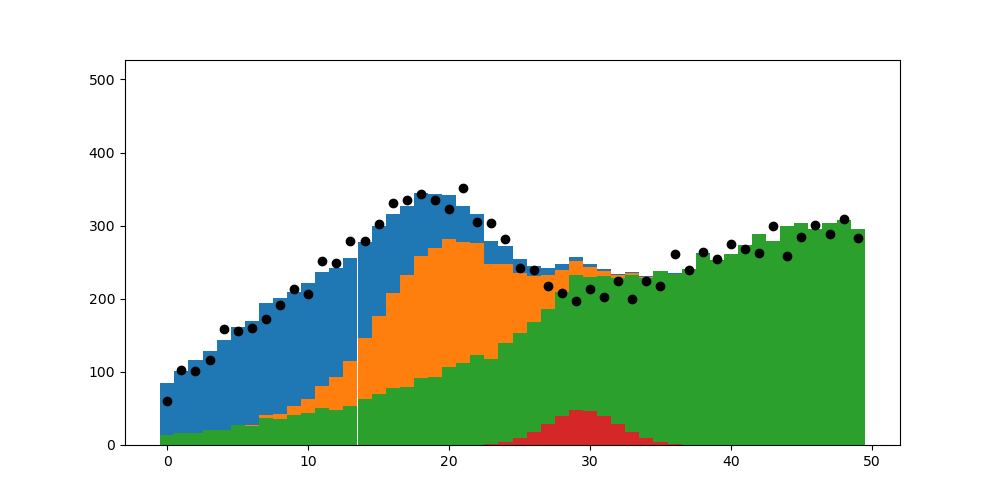

In [85]:
%matplotlib ipympl
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 5)
ax.set_ylim(0, 1.5 * np.max(workspace.data(pdf, include_auxdata=False)))

init_plot(fig, ax)
interact(animate, fig=fixed(fig), ax=fixed(ax), **all_par_settings);

and with this in hand, we can go ahead and check how things look for background, signal+background, and the best fit parameters:

In [86]:
nominal = pdf.config.suggested_init()
background_only = pdf.config.suggested_init()
background_only[pdf.config.poi_index] = 0.0
best_fit = pyhf.infer.mle.fit(data, pdf)

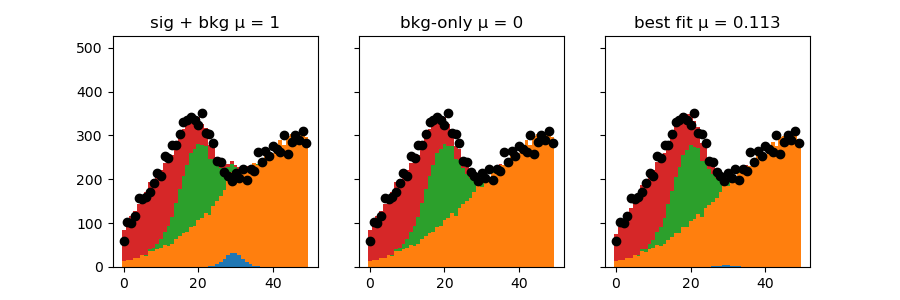

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)
fig.set_size_inches(9, 3)
ax1.set_ylim(0, 1.5 * np.max(workspace.data(pdf, include_auxdata=False)))
ax1.set_title('sig + bkg µ = 1')
plot(ax=ax1, **{k: nominal[v] for k, v in par_name_dict.items()})

ax2.set_title('bkg-only µ = 0')
plot(ax=ax2, **{k: background_only[v] for k, v in par_name_dict.items()})

ax3.set_title(f'best fit µ = {best_fit[pdf.config.poi_index]:.3g}')
plot(ax=ax3, **{k: best_fit[v] for k, v in par_name_dict.items()});

## Using HEPData

As of this tutorial, ATLAS has [published 33 full statistical models to HEPData](https://pyhf.github.io/public-probability-models/atlas.json)

<p align="center">
<a href="https://www.hepdata.net/record/ins1755298?version=3"><img src="https://raw.githubusercontent.com/matthewfeickert/talk-SciPy-2020/e0c509cd0dfef98f5876071edd4c60aff9199a1b/figures/HEPData_likelihoods.png"></a>
</p>

Let's explore the 1Lbb workspace a little bit shall we?

### Getting the Data

We'll use the `pyhf[contrib]` extra (which relies on `requests` and `tarfile`) to download the HEPData minted DOI and extract the files we need.

In [88]:
pyhf.contrib.utils.download(
    "https://doi.org/10.17182/hepdata.90607.v3/r3", "1Lbb-likelihoods"
)

This will nicely download and extract everything we need.

In [89]:
!ls -lavh 1Lbb-likelihoods

total 120664
drwxr-xr-x@  5 kratsg  staff   160B Oct 15 14:23 .
drwxr-xr-x@ 20 kratsg  staff   640B Oct 15 14:23 ..
-rw-r--r--@  1 kratsg  staff   4.2M May  7  2020 BkgOnly.json
-rw-r--r--@  1 kratsg  staff   1.3K May 30  2020 README.md
-rw-r--r--@  1 kratsg  staff    55M May 31  2020 patchset.json


### Instantiate our objects

We have a background-only workspace `BkgOnly.json` and a signal patchset collection `patchset.json`. Let's create our python objects and play with them:

In [90]:
spec = json.load(open("1Lbb-likelihoods/BkgOnly.json"))
patchset = pyhf.PatchSet(json.load(open("1Lbb-likelihoods/patchset.json")))

So what did the analyzers give us for signal patches?

### Patching in Signals

Let's look at this [`pyhf.PatchSet`](https://pyhf.readthedocs.io/en/v0.7.5/_generated/pyhf.patchset.PatchSet.html#pyhf.patchset.PatchSet) object which provides a user-friendly way to interact with many signal patches at once.

#### PatchSet

In [91]:
patchset

<pyhf.patchset.PatchSet object with 125 patches at 0x311f4a7b0>

Oh wow, we've got 125 patches. What information does it have?

In [92]:
print(f"description: {patchset.description}")
print(f"    digests: {patchset.digests}")
print(f"     labels: {patchset.labels}")
print(f" references: {patchset.references}")
print(f"    version: {patchset.version}")

description: signal patchset for the SUSY EWK 1Lbb analysis
    digests: {'sha256': '2563672e1a165384faf49f1431e921d88c9c07ec10f150d5045576564f98f820'}
     labels: ['m1', 'm2']
 references: {'hepdata': 'ins1755298'}
    version: 1.0.0


So we've got a useful description of the signal patches... there's a digest. Does that match the background-only workspace we have?

In [93]:
pyhf.utils.digest(spec)

'2563672e1a165384faf49f1431e921d88c9c07ec10f150d5045576564f98f820'

It does! In fact, this sort of verification check will be done automatically when applying patches using `pyhf.PatchSet` as we will see shortly. To manually verify, simply run `pyhf.PatchSet.verify` on the workspace. No error means everything is fine. It will loudly complain otherwise.

In [95]:
patchset.verify(spec)

No error, whew. Let's move on.

The labels `m1` and `m2` tells us that we have the signal patches parametrized in 2-dimensional space, likely as $m_1 = \tilde{\chi}_1^\pm$ and $m_2 = \tilde{\chi}_1^0$... but I guess we'll see?

The references list the references for this dataset, which is pointing at the hepdata record for now.

Next, the version is the version of the schema set we're using with `pyhf` (`1.0.0`).

And last, but certainly not least... its patches:

In [97]:
patchset.patches

[<pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_0(1000, 0)' at 0x311f48ec0>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_100(1000, 100)' at 0x3164eae90>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_150(1000, 150)' at 0x3164e9e50>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_200(1000, 200)' at 0x176af7360>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_250(1000, 250)' at 0x3115d23f0>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_300(1000, 300)' at 0x1767af1d0>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_350(1000, 350)' at 0x176c2cf30>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_400(1000, 400)' at 0x3112e5e10>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_1000_50(1000, 50)' at 0x3116c5650>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_150_0(150, 0)' at 0x3116c6e50>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_165_35(165, 35)' at 0x310efc7d0>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_175_0(175, 0)' at 0x310eff110>,
 <pyhf.patchset.Patch object 'C1N2_Wh_hbb_175_25(175, 25)' at 

So we can see all the patches listed both by name such as `C1N2_Wh_hbb_900_250` as well as a pair of points `(900, 250)`. Why is this useful? The `PatchSet` object acts like a special dictionary look-up where it will grab the patch you need based on the unique key you provide it.

For example, we can look up by name

In [98]:
patchset["C1N2_Wh_hbb_900_250"]

<pyhf.patchset.Patch object 'C1N2_Wh_hbb_900_250(900, 250)' at 0x324e48650>

or by the pair of points

In [99]:
patchset[(900, 250)]

<pyhf.patchset.Patch object 'C1N2_Wh_hbb_900_250(900, 250)' at 0x324e48650>

#### Patches

A `pyhf.PatchSet` is a collection of `pyhf.Patch` objects. What is a patch indeed? It contains enough information about how to apply the signal patch to the corresponding background-only workspace (matched by digest).

In [100]:
patch = patchset["C1N2_Wh_hbb_900_250"]
print(f"  name: {patch.name}")
print(f"values: {patch.values}")

  name: C1N2_Wh_hbb_900_250
values: (900, 250)


Most importantly, it contains the patch information itself. Specifically, this inherits from the `jsonpatch.JsonPatch` object, which is a 3rd party module providing native support for json patching in python. That means we can simply apply the patch to our workspace directly!

In [101]:
print(f" samples pre-patch: {pyhf.Workspace(spec).samples}")
print(f"samples post-patch: {pyhf.Workspace(patch.apply(spec)).samples}")

 samples pre-patch: ['diboson', 'multiboson', 'singletop', 'ttbar', 'tth', 'ttv', 'vh', 'wjets', 'zjets']
samples post-patch: ['C1N2_Wh_hbb_900_250', 'diboson', 'multiboson', 'singletop', 'ttbar', 'tth', 'ttv', 'vh', 'wjets', 'zjets']


Or, more quickly, from the `PatchSet` object:

In [102]:
print(f" samples pre-patch: {pyhf.Workspace(spec).samples}")
print(f"samples post-patch: {pyhf.Workspace(patchset.apply(spec, (900, 250))).samples}")

 samples pre-patch: ['diboson', 'multiboson', 'singletop', 'ttbar', 'tth', 'ttv', 'vh', 'wjets', 'zjets']
samples post-patch: ['C1N2_Wh_hbb_900_250', 'diboson', 'multiboson', 'singletop', 'ttbar', 'tth', 'ttv', 'vh', 'wjets', 'zjets']


#### Patching via Model Creation

One last way to apply the patching is to, instead of patching workspaces, we patch the models as we build them from the background-only workspace. This maybe makes it easier to treat the background-only workspace as immutable, and patch in signal models when grabbing the model. Check it out.

In [103]:
workspace = pyhf.Workspace(spec)

First, load up our background-only spec into the workspace. Then let's create a model.

In [104]:
model = workspace.model(patches=[patchset["C1N2_Wh_hbb_900_250"]])
print(f"samples (workspace): {workspace.samples}")
print(f"samples (  model  ): {model.config.samples}")

samples (workspace): ['diboson', 'multiboson', 'singletop', 'ttbar', 'tth', 'ttv', 'vh', 'wjets', 'zjets']
samples (  model  ): ['C1N2_Wh_hbb_900_250', 'diboson', 'multiboson', 'singletop', 'ttbar', 'tth', 'ttv', 'vh', 'wjets', 'zjets']
